In [44]:
import os
import numpy as np
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt

from settings import client_id, client_secret, config_name, config_file

from ipyleaflet import GeoJSON, Map, basemaps
from sentinelhub import SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType, SentinelHubDownloadClient


In [19]:
config = None

if os.path.isfile(config_file):
    config = SHConfig(open(config_file, "r").read())
else:
    config = SHConfig()
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    config.sh_base_url = "https://sh.dataspace.copernicus.eu"
    config.save(config_name)

    open(config_file, "w").write(config_name)


In [26]:
resolution = (20, 20)
bbox_coords = [24.535925,57.703207, 24.550066, 57.710945]
epsg = 3035

# Convert to 3035 to get crs with meters as units
bbox = BBox(bbox_coords, CRS(4326)).transform(epsg)
x, y = bbox.transform(4326).middle

overview_map = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=(y, x), zoom=10)
geo_json = GeoJSON(data=bbox.transform(4326).geojson)
overview_map.add_layer(geo_json)


In [28]:
evalscript_sar = """
  function setup() {
    return {
      input: ["VV", "dataMask"],
      output: { bands: 2, sampleType: "FLOAT32"}
    }
  }


// visualizes decibels from -20 to +10
function toDb(linear) {
  var log = 10 * Math.log(linear) / Math.LN10
  return Math.max(0, (log + 20) / 30)
}

function evaluatePixel(sample) {
  var VV = sample.VV;

  return [toDb(VV),sample.dataMask];
}
"""


def get_sar_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_sar,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    "s1iw", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                other_args={
                    "dataFilter": {
                        "resolution": "HIGH",
                        "mosaickingOrder": "mostRecent",
                        "orbitDirection": "ASCENDING",
                    },
                    "processing": {
                        "backCoeff": "SIGMA0_ELLIPSOID",
                        "orthorectify": True,
                        "demInstance": "COPERNICUS",
                        "speckleFilter": {
                            "type": "LEE",
                            "windowSizeX": 3,
                            "windowSizeY": 3,
                        },
                    },
                },
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=bbox,
        resolution=resolution,
        config=config,
        data_folder="./results",
    )

In [48]:
start = datetime.datetime(2021, 9, 1)
end = datetime.datetime(2024, 4, 30)
n_chunks = 17
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)


Monthly time windows:

('2021-09-01', '2021-10-28')
('2021-10-28', '2021-12-24')
('2021-12-24', '2022-02-19')
('2022-02-19', '2022-04-17')
('2022-04-17', '2022-06-13')
('2022-06-13', '2022-08-10')
('2022-08-10', '2022-10-06')
('2022-10-06', '2022-12-02')
('2022-12-02', '2023-01-28')
('2023-01-28', '2023-03-26')
('2023-03-26', '2023-05-22')
('2023-05-22', '2023-07-19')
('2023-07-19', '2023-09-14')
('2023-09-14', '2023-11-10')
('2023-11-10', '2024-01-06')
('2024-01-06', '2024-03-03')


In [49]:
# create a list of requests
list_of_requests = [get_sar_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(
    list_of_requests, max_threads=5
)


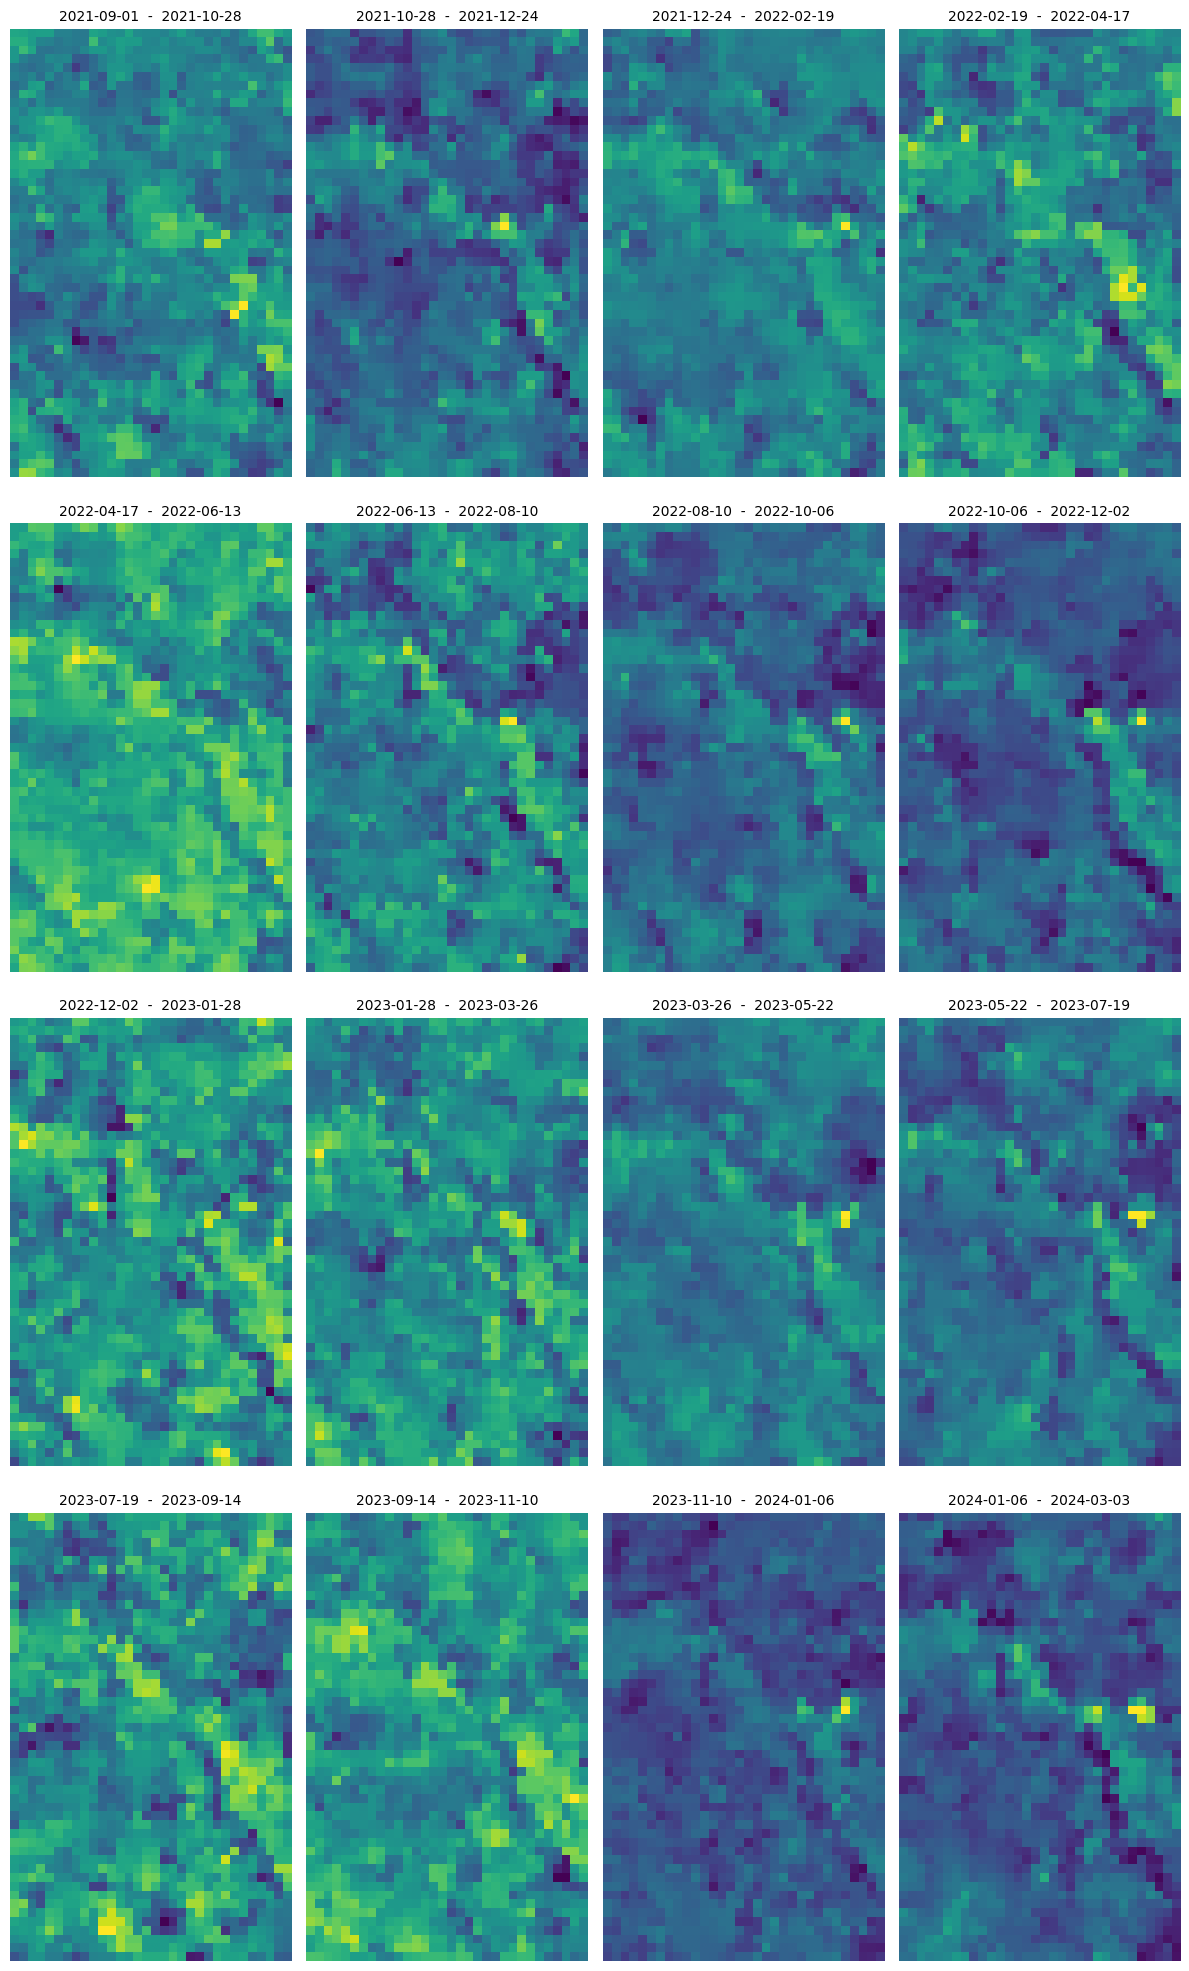

In [52]:
ncols = 4
nrows = 4
aspect_ratio = 1.5
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(2 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip((image[:, :, 0]) * 3.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()


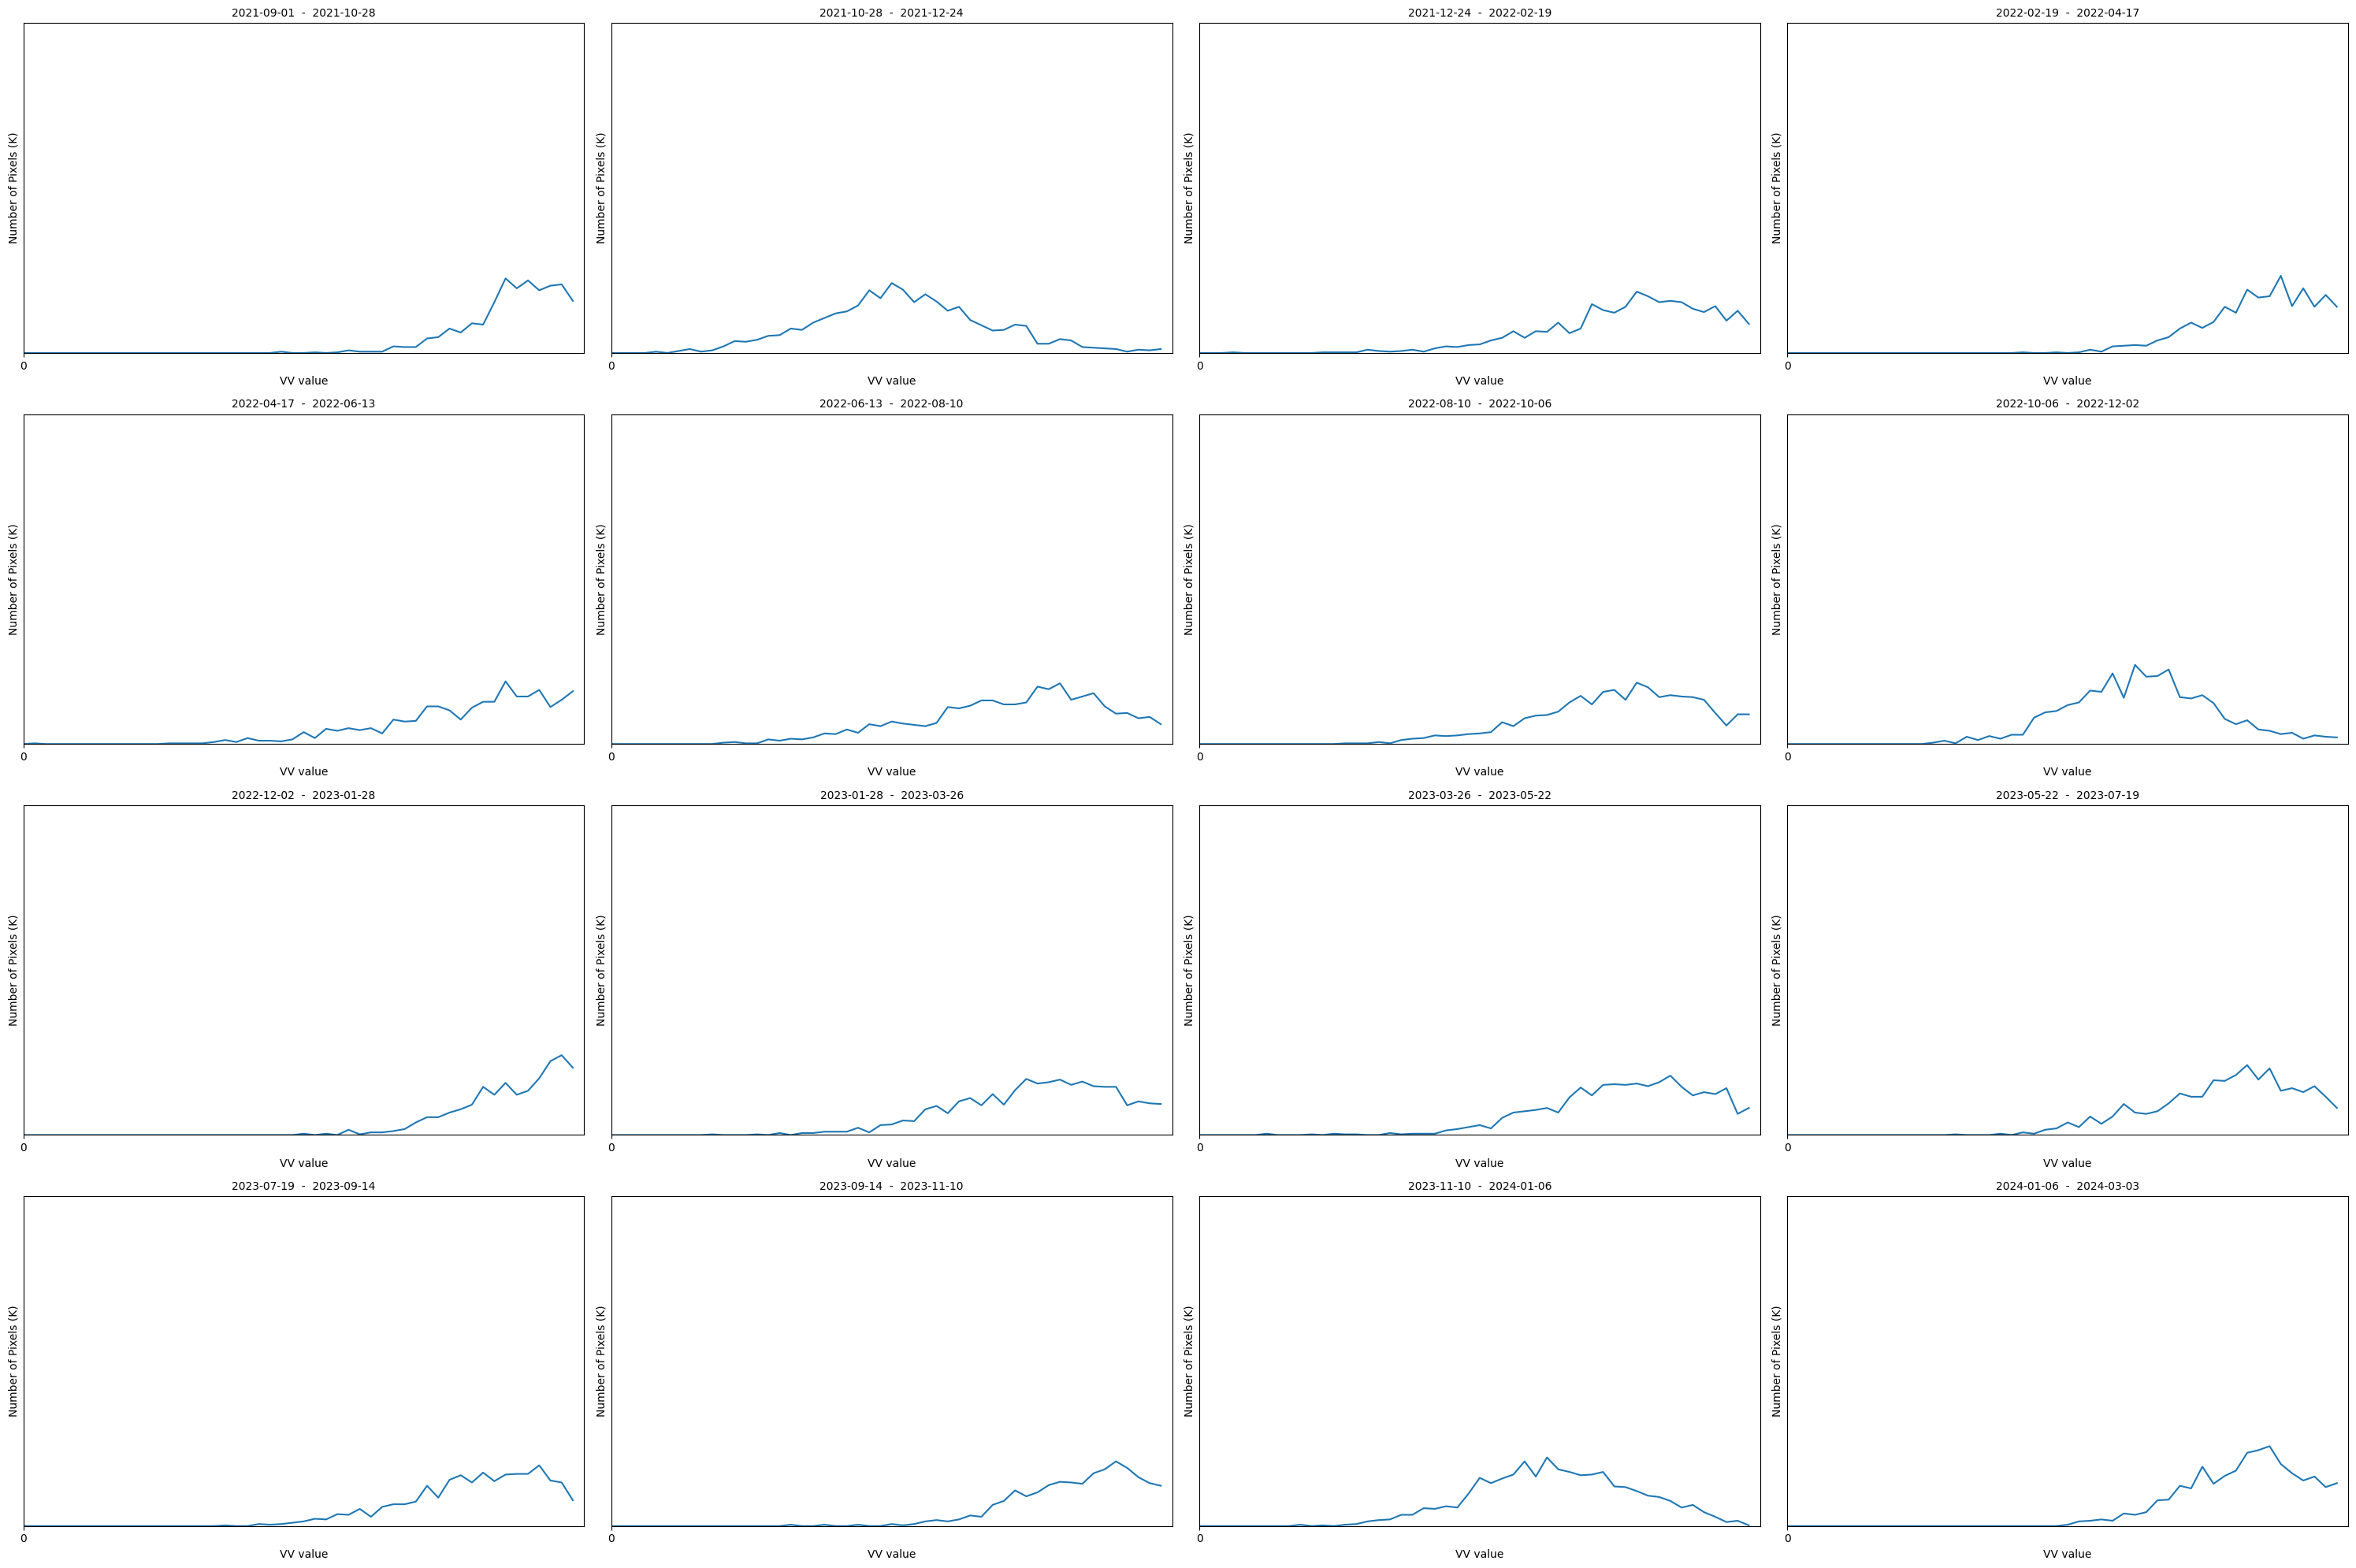

In [51]:
ncols = 4
nrows = 4
aspect_ratio = 15 / 10
subplot_kw = {"xticks": range(0, 255, 25), "yticks": [], "frame_on": True}

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(5 * ncols * aspect_ratio, 5 * nrows),
    subplot_kw=subplot_kw,
)

for idx, image in enumerate(data):
    histogram, bin_edges = np.histogram(
        2.5 * image[:, :, 0], bins=50, range=(0.0000001, 1)
    )
    ax = axs[idx // ncols][idx % ncols]
    ax.plot(bin_edges[0:-1], histogram)
    ax.set_xlabel("VV value")
    ax.set_ylabel("Number of Pixels (K)")
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 500))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()
